This notebook accompanies the Whisper Connected Fracture Analysis note.

In [13]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString

from pyfracman.data import clean_columns
from pyfracman.fab import parse_fab_file
from pyfracman.frac_geo import flatten_frac, get_mid_z, get_fracture_set_stats
from pyfracman.well_geo import (
    load_stage_location,
    load_survey_export, 
    well_surveys_to_linestrings, 
    stage_locs_to_gdf
    )

In [2]:
data_dir = Path(r"C:\Users\scott.mckean\Desktop\Data Exports")

In [3]:
# load fractures
frac_fpath = next(data_dir.rglob("Interpreted_Seismic_Lineaments.fab"))
fracs = parse_fab_file(frac_fpath)

In [4]:
### Load fractures ###

# load fracture properties
# parse average properties per fracture
# must average for tesselated fractures
if len(fracs.get('t_properties')) > 0:
    fracs['prop_list'] = [np.mean(x, axis=1) for x in fracs['t_properties']]
    prop_df = pd.DataFrame(fracs['prop_list'], columns = fracs['prop_dict'].values(), index=fracs['t_fid'])
else:
    prop_df = pd.DataFrame(fracs['prop_list'], columns = fracs['prop_dict'].values(), index=fracs['fid'])

prop_df.index.set_names('fid', inplace=True)

# load fracture geometry and flatten to 2D at midpoint of frac plane
if len(fracs.get('t_nodes')) > 0:
    frac_linestrings = list(map(flatten_frac, fracs['t_nodes']))
    frac_mid_z = list(map(get_mid_z, fracs['t_nodes']))
else:
    frac_linestrings = list(map(flatten_frac, fracs['fracs']))
    frac_mid_z = list(map(get_mid_z, fracs['fracs']))

frac_gdf = gpd.GeoDataFrame(prop_df, geometry=frac_linestrings)

In [5]:
# for stochastic connections - don't need this yet
conn_out = []
for conn_fpath in data_dir.rglob("*_Connections.txt"):
    set_a = get_fracture_set_stats(conn_fpath, set_name='Stochastic Faults - Set A_1', set_alias='set_a')
    set_b = get_fracture_set_stats(conn_fpath, set_name='Stochastic Faults - Set B_1', set_alias='set_b')
    sets = set_a.merge(set_b, on=['stage_no','well','object'])
    conn_out.append(sets)

stochastic_connections = pd.concat(conn_out)

In [66]:
### load stages and surveys ###
# load surveys and convert to linestrings
surveys = pd.concat(
    [load_survey_export(well_path) for well_path in data_dir.glob("*_well.txt")]
)
survey_linestrings = well_surveys_to_linestrings(surveys)

# load stage locations and convert to GDF with points and linestring
stage_locs = pd.concat(
    [load_stage_location(well_path) for well_path in data_dir.glob("*_intervals.txt")]
)
stage_gdf = stage_locs_to_gdf(stage_locs)

# get stage start times, with clean non-flowback for geometry merge
stage_times = pd.read_parquet(data_dir / "stage_times.parquet")
stage_times['stage_w_f'] = stage_times['stage'].copy()
stage_times['stage'] = stage_times['stage_w_f'].astype(int)

In [84]:
# load manual connections
manual_map = pd.read_excel(data_dir / 'Stage - Event Array.xlsx', skiprows=1)
connections = manual_map.iloc[:,2:].apply(lambda x: x.dropna().unique().astype(int), axis=1)
connections.name = 'connections'

# get well and stage
well_stg = manual_map.Stage.str.split("_",expand=True)
well_stg.columns = ['well', 'stage']
manual_connections = pd.concat([well_stg, connections], axis=1)
manual_connections['stage_w_f'] = manual_connections['stage'].copy()
manual_connections['stage_w_f'] = manual_connections['stage_w_f'].str.replace('F',".5").astype(float)
manual_connections['stage'] = manual_connections['stage_w_f'].astype(int)

# add stage geometry and start times
manual_connections = (manual_connections
    .merge(stage_times, on=['well','stage_w_f','stage'], how='left')
    .merge(stage_gdf, on=['well','stage'], how='left')
    .pipe(gpd.GeoDataFrame)
    )

In [99]:
# load manual f
lineaments = pd.read_csv(data_dir / 'Seismic Lineament centres.csv')
lineaments.columns = clean_columns(lineaments.columns)
lineaments = gpd.GeoDataFrame(lineaments, geometry=gpd.points_from_xy(lineaments['x'], lineaments['y']))
lineaments.head()

,row labels,id,x,y,z,geometry
0,SeisLineamt_ID_1,1,1763.58,-875.250,-255.701,POINT (1763.580 -875.250)
1,SeisLineamt_ID_10,10,1856.17,-412.361,-255.701,POINT (1856.170 -412.361)
2,SeisLineamt_ID_11,11,1417.78,-596.620,-255.701,POINT (1417.780 -596.620)
3,SeisLineamt_ID_12,12,1366.63,-678.503,-255.701,POINT (1366.630 -678.503)
4,SeisLineamt_ID_13,13,1383.50,-582.402,-255.701,POINT (1383.500 -582.402)


In [133]:
connections_out = []
for i, row in manual_connections.iterrows():
    for conn_fid in row.connections:
        # make one row per connection, with a single geometry
        stg_geom = row.geometry
        frac_geom = lineaments.query("id == @conn_fid").geometry.iloc[0]
        conn_geom = LineString([stg_geom, frac_geom])
        conn_out = gpd.GeoDataFrame(
            row.to_frame().transpose()[['well','stage','well_stage','start_date','is_count']].reset_index(),
            geometry=[conn_geom]
            )
        conn_out['fid'] = conn_fid
        conn_out['start_date'] = conn_out.start_date.astype(str)
        connections_out.append(conn_out)

In [134]:
connections_out = pd.concat(connections_out)

In [140]:
connections_out.to_file(data_dir / 'manual_connections.shp')
connections_out.to_file(data_dir / 'manual_connections.geojson', driver='GeoJSON')

C:\Users\scott.mckean\Miniconda3\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [139]:
connections_out.query("well_stage == 'A6_28F'")

,index,well,stage,well_stage,start_date,is_count,geometry,fid
0,102,A6,28,A6_28F,2019-10-04 19:20:00,13,"LINESTRING (628.761 -451.368, 843.699 -635.682)",22
0,102,A6,28,A6_28F,2019-10-04 19:20:00,13,"LINESTRING (628.761 -451.368, 1110.460 -664.957)",19
0,102,A6,28,A6_28F,2019-10-04 19:20:00,13,"LINESTRING (628.761 -451.368, 678.517 -873.950)",21


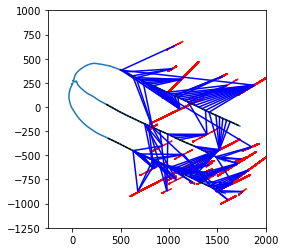

In [137]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
survey_linestrings.plot(ax = ax)
frac_gdf.plot(ax = ax, color='r')
stage_gdf.set_geometry('stg_line').plot(ax = ax, color='k')
connections_out.plot(ax = ax, color='b')
ax.set_aspect('equal')
plt.xlim(-250, 2000)
plt.ylim(-1250, 1000)
plt.show()